In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer


/tmp/ipykernel_13832/3031155135.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('data/SBAnational.csv', dtype='unicode')


In [3]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [4]:
df.isna().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [5]:
df = df[['Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'GrAppv','MIS_Status']]


In [6]:
# Ne prend en compte que les deux premiers chiffres des codes
df['NAICS'] = df['NAICS'].apply(lambda x: int(str(x)[:2]))

In [7]:
# converti ApprovalDate
df['ApprovalDate'] = pd.to_datetime(df['ApprovalDate'], format='%d-%b-%y')


In [8]:
# Corrige les erreur de ApprovalFY
df['ApprovalFY'].replace('1976A', 1976, inplace=True)

#converti la colonne en int
df['ApprovalFY'] = df['ApprovalFY'].astype(int)

/tmp/ipykernel_13832/164197403.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ApprovalFY'].replace('1976A', 1976, inplace=True)


In [9]:
# Supprimer le signe dollar 
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('$', ''))

# supprimer la virgule
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace(',', ''))

# supprimer le point
df['GrAppv'] = df['GrAppv'].apply(lambda x: x.replace('.', ''))

# Convertir en int
df['GrAppv'] = df['GrAppv'].astype(int)    

In [10]:
# Transforme les valeurs de la target
df['MIS_Status'] = df['MIS_Status'].replace({'P I F' : 1, 'CHGOFF':0})

/tmp/ipykernel_13832/851188240.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['MIS_Status'] = df['MIS_Status'].replace({'P I F' : 1, 'CHGOFF':0})


In [11]:
# Corrige la colonne LowDoc
# Remplacement de '[C,S,A,R,1,0]' par NaN
df['LowDoc'] = df['LowDoc'].replace({'[C,S,A,R,1,0]': np.nan})

# Remplacement de 'N' par 0 et 'Y' par 1
df['LowDoc'] = df['LowDoc'].replace({'N': 0, 'Y': 1})

# Remplacement des valeurs différentes de 0 et 1 par NaN
df['LowDoc'] = np.where((df['LowDoc'] != 0) & (df['LowDoc'] != 1), np.nan, df['LowDoc'])


In [12]:
#Corrige la colonne RevLineCr
# Remplacement des valeurs 'N' par 0 et 'Y' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'N': 0, 'Y': 1})

# Remplacement des chaînes '0' par 0 et '1' par 1
df['RevLineCr'] = df['RevLineCr'].replace({'0': 0, '1': 1})

#  Remplacement des valeurs différentes de 0 et 1 par NaN
df['RevLineCr'] = np.where((df['RevLineCr'] != 0) & (df['RevLineCr'] != 1), np.nan, df['RevLineCr'])


In [13]:
#Corrige la colonne NewExist
selected_column = df['NewExist']
replaced_values = selected_column.replace({1.0: 0, 2.0: 1, 0: np.nan})
filled_values = replaced_values.fillna(0)
final_result = filled_values.astype(int)
df['NewExist'] = final_result

In [14]:
# Données manquantes
df.isnull().sum()

Name                14
City                30
State               14
Zip                  0
Bank              1559
BankState         1566
NAICS                0
ApprovalDate         0
ApprovalFY           0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr        19854
LowDoc            6007
GrAppv               0
MIS_Status        1997
dtype: int64

In [15]:
# Les doublons
df.duplicated().sum()

232

In [16]:
df.dtypes


Name                     object
City                     object
State                    object
Zip                      object
Bank                     object
BankState                object
NAICS                     int64
ApprovalDate     datetime64[ns]
ApprovalFY                int64
Term                     object
NoEmp                    object
NewExist                  int64
CreateJob                object
RetainedJob              object
FranchiseCode            object
UrbanRural               object
RevLineCr                object
LowDoc                   object
GrAppv                    int64
MIS_Status              float64
dtype: object

In [17]:
# Secteurs du NAICS
secteurs = {
    11 : 'Agriculture, forest, fishing',
    21 : 'Mining, oil, Gaz',
    22 : 'Utilities',
    23 : 'Construction',
    31 : 'Manufacturing',
    32 : 'Manufacturing',
    33 : 'Manufacturing',
    42 : 'Wolesale trade',
    44 : 'Retail trade',
    45 : 'Retail trade',
    48 : 'Transportation and warehousing',
    49 : 'Transportation and warehousing',
    51 : 'Information',
    52 : 'Finance and insurance',
    53 : 'Real estate and rental, leasing',
    54 : 'Professional, scientific, technical services',
    55 : 'Management of companies and entreprises',
    56 : 'Administrative and support',
    61 : 'Educational services',
    62 : 'Health care and social',
    71 : 'Arts, entertainment',
    81 : 'Other services',
    92 : 'Public administration'
}

In [18]:
# Colonne qui indique les secteurs du NAICS
df['Sectors'] = df['NAICS'].map(secteurs)


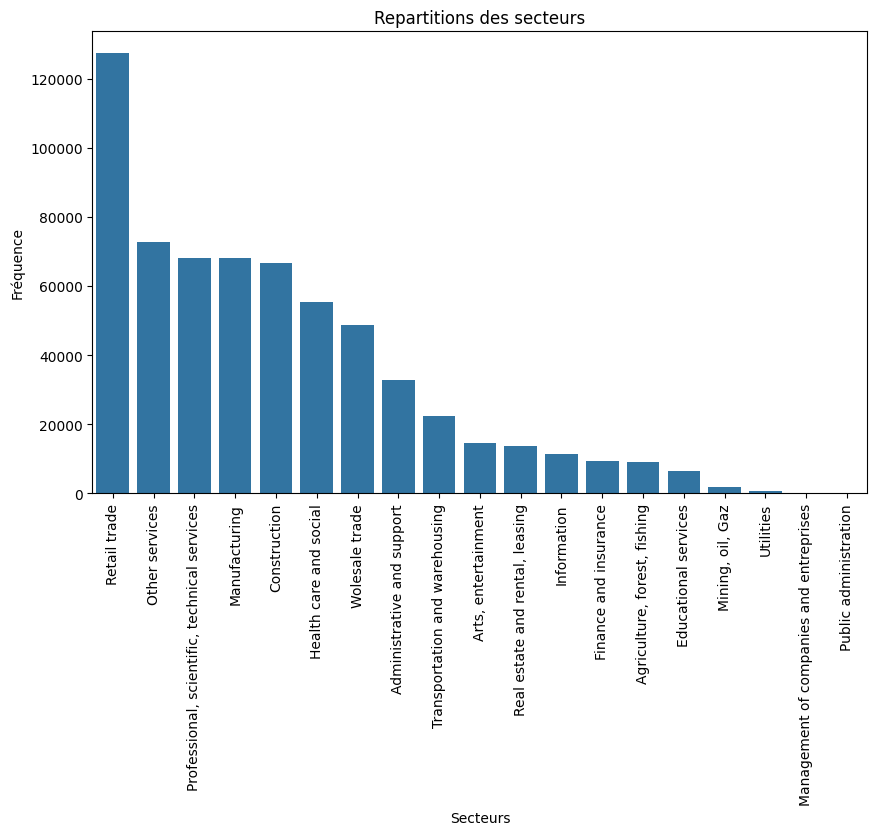

In [19]:
sector_counts = df['Sectors'].value_counts()

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Repartitions des secteurs')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

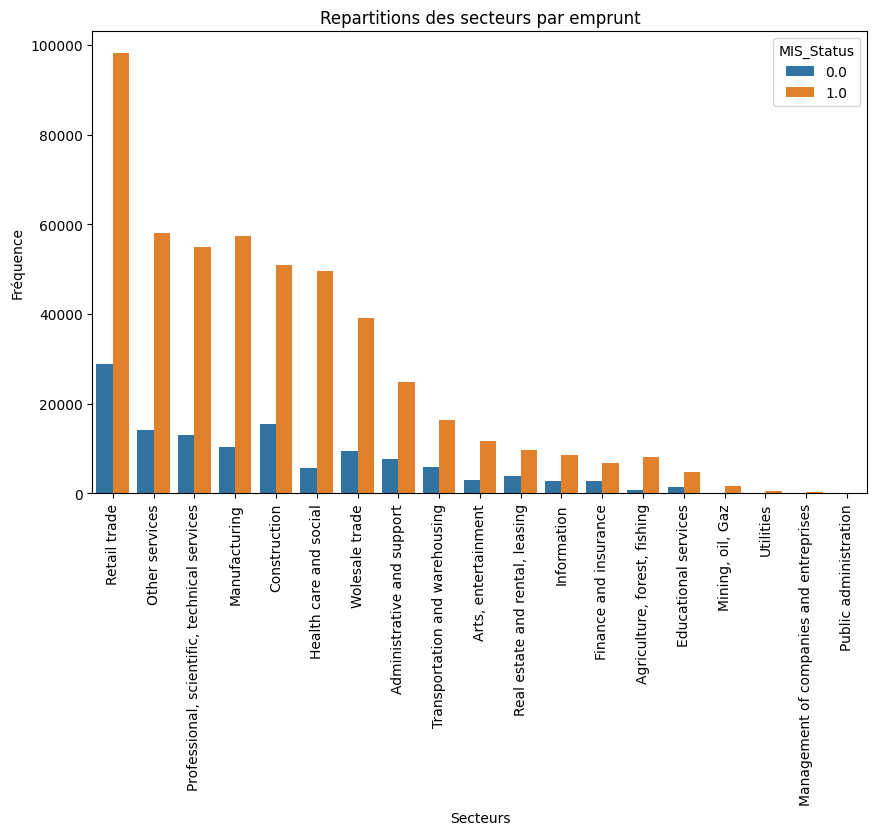

In [20]:
sector_counts = df['Sectors'].value_counts()
order = sector_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='Sectors', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions des secteurs par emprunt')
plt.xlabel('Secteurs')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

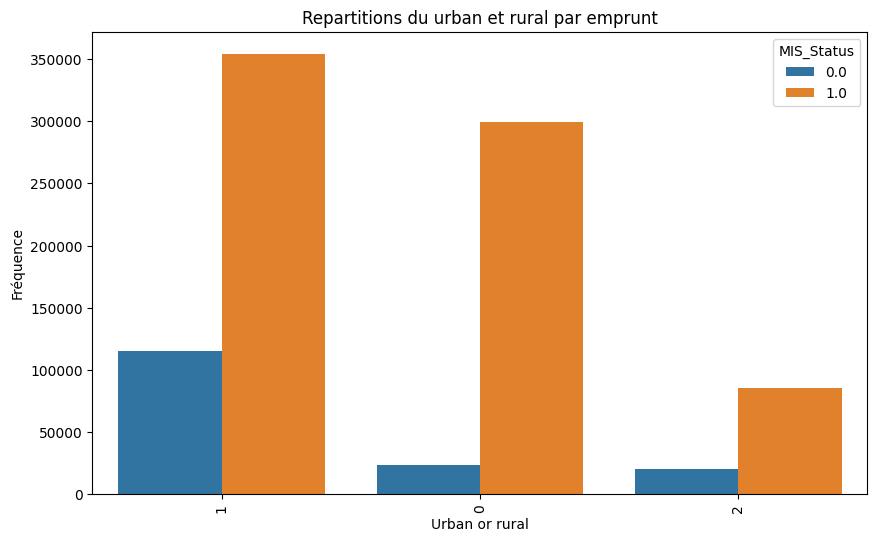

In [21]:
urban_counts = df['UrbanRural'].value_counts()
order = urban_counts.index

# Création du diagramme en barres
plt.figure(figsize=(10, 6))
sns.countplot(x='UrbanRural', hue='MIS_Status', data=df, order=order)
plt.title('Repartitions du urban et rural par emprunt')
plt.xlabel('Urban or rural')
plt.xticks(rotation = 90)
plt.ylabel('Fréquence')
plt.show()

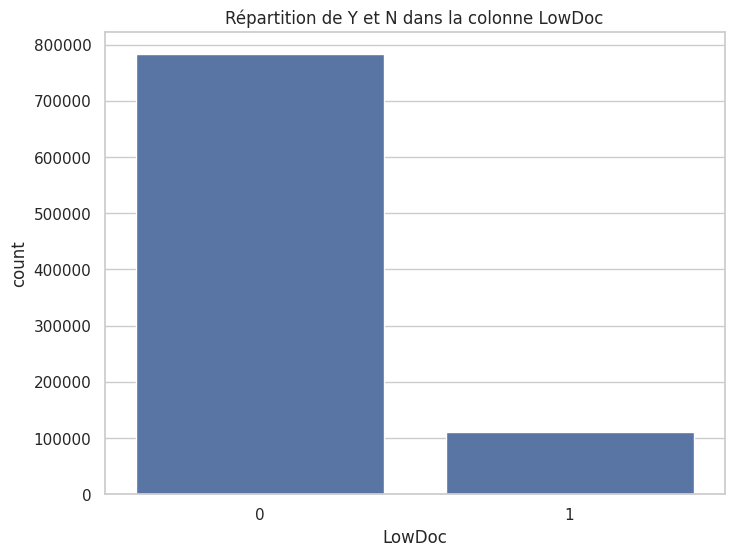

In [22]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='LowDoc', data=df)

plt.title('Répartition de Y et N dans la colonne LowDoc')
plt.show()

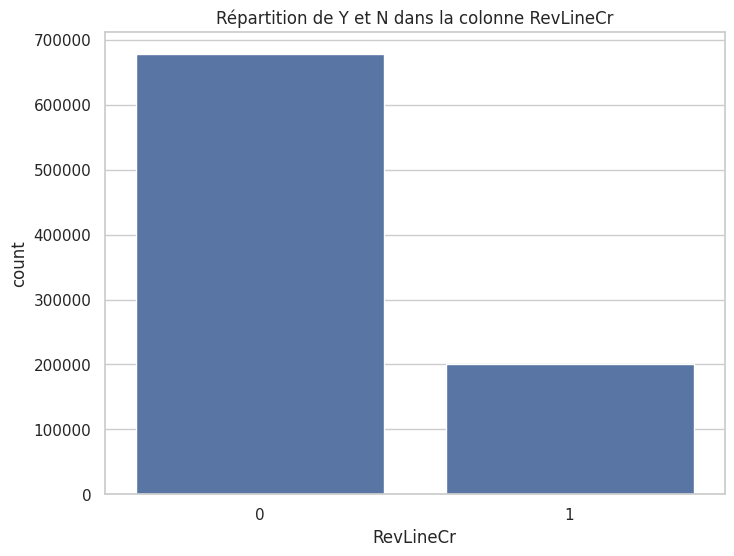

[0 1 nan]


In [31]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='RevLineCr', data=df)

plt.title('Répartition de Y et N dans la colonne RevLineCr')
plt.show()
print(df['RevLineCr'].unique())

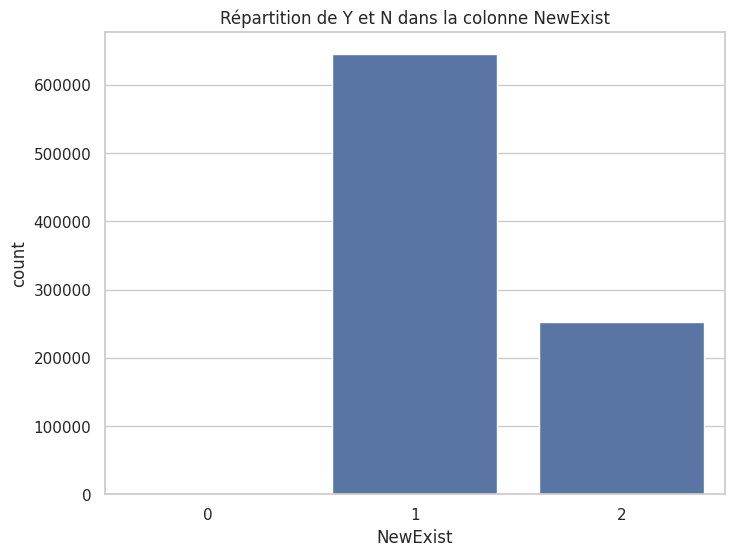

In [24]:

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.countplot(x='NewExist', data=df)

plt.title('Répartition de Y et N dans la colonne NewExist')
plt.show()

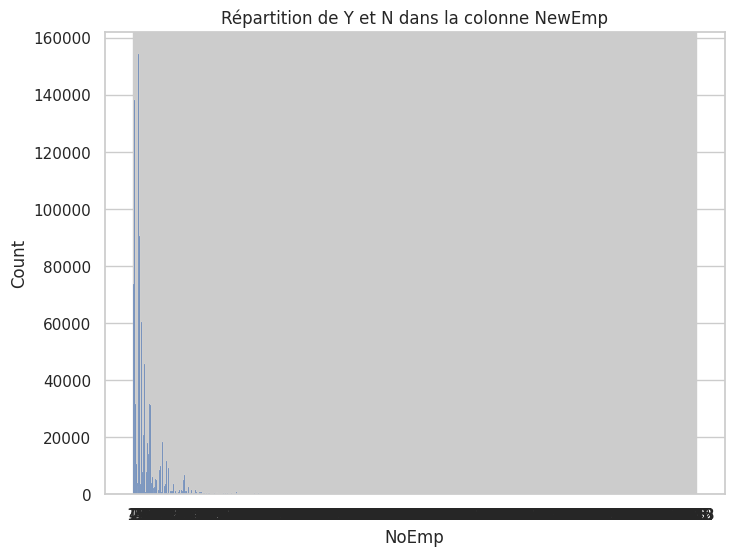

In [25]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

# Utilise la fonction countplot de Seaborn
sns.histplot(x=df['NoEmp'], data=df)

plt.title('Répartition de Y et N dans la colonne NewEmp')
plt.show()

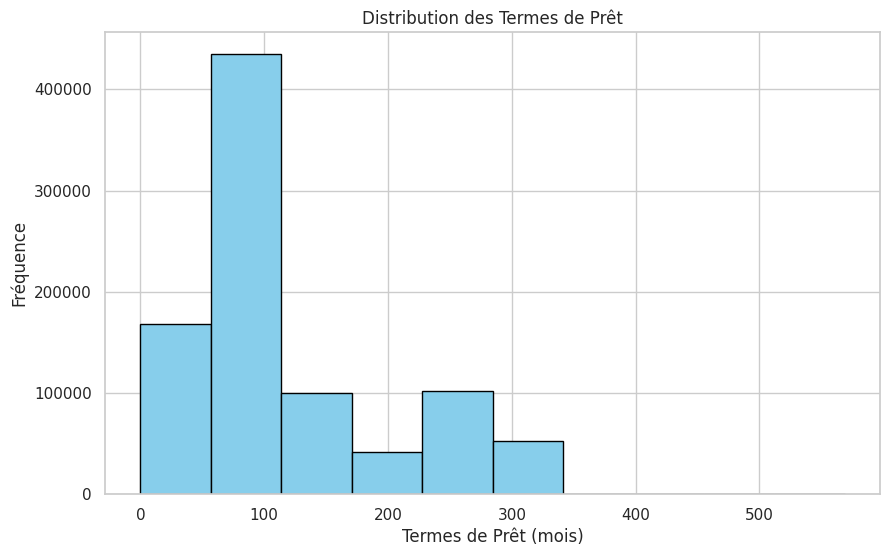

In [26]:
df['Term'] = pd.to_numeric(df['Term'], errors='coerce')

# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['Term'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Termes de Prêt')
plt.xlabel('Termes de Prêt (mois)')
plt.ylabel('Fréquence')
plt.show()

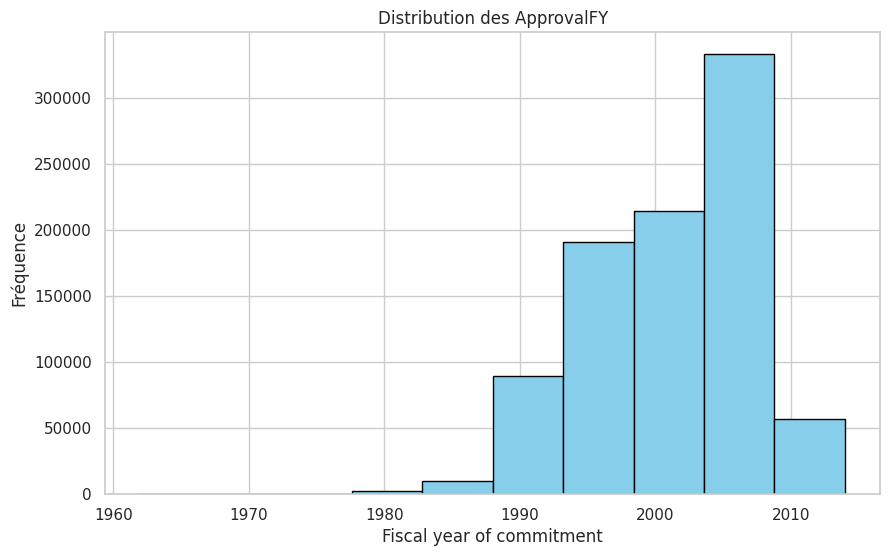

In [27]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalFY'].dropna(), color='skyblue', edgecolor='black')
plt.title('Distribution des ApprovalFY')
plt.xlabel('Fiscal year of commitment')
plt.ylabel('Fréquence')
plt.show()

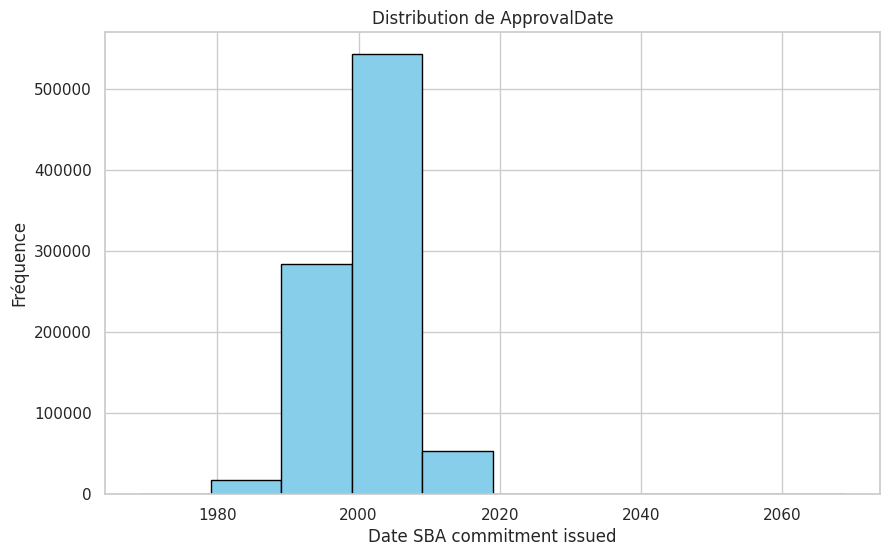

In [28]:
# Créer un histogramme
plt.figure(figsize=(10, 6))
plt.hist(df['ApprovalDate'].dropna(), bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution de ApprovalDate')
plt.xlabel('Date SBA commitment issued')
plt.ylabel('Fréquence')
plt.show()

In [29]:
df.columns

Index(['Name', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS',
       'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist', 'CreateJob',
       'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc',
       'GrAppv', 'MIS_Status', 'Sectors'],
      dtype='object')

In [30]:
df.dtypes

Name                     object
City                     object
State                    object
Zip                      object
Bank                     object
BankState                object
NAICS                     int64
ApprovalDate     datetime64[ns]
ApprovalFY                int64
Term                      int64
NoEmp                    object
NewExist                  int64
CreateJob                object
RetainedJob              object
FranchiseCode            object
UrbanRural               object
RevLineCr                object
LowDoc                   object
GrAppv                    int64
MIS_Status              float64
Sectors                  object
dtype: object